# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
!pip install imbalanced-learn
from sklearn.feature_selection import mutual_info_classif as mic
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
!pip install pycountry_convert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 16.8 MB/s eta 0:00:00


# Data Loading and Summary statistics

In [3]:
data= pd.read_csv('/content/customer_booking (1).csv',encoding='latin-1')
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


## Understanding data

In [ ]:
data['sales_channel'].unique()

array(['Internet', 'Mobile'], dtype=object)

In [ ]:
data['trip_type'].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [ ]:
data.isnull().sum()

,0
num_passengers,0
sales_channel,0
trip_type,0
purchase_lead,0
length_of_stay,0
flight_hour,0
flight_day,0
route,0
booking_origin,0
wants_extra_baggage,0


In [ ]:
data.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

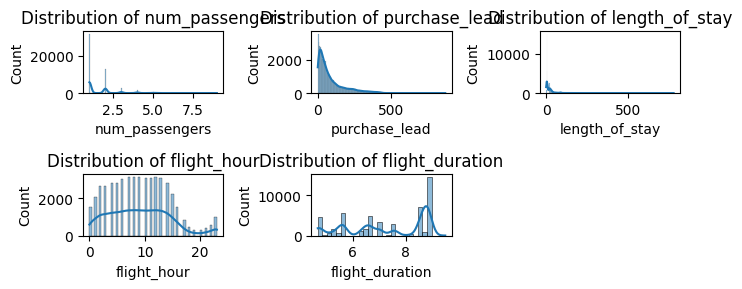

In [4]:
numerical_cols = ['num_passengers',  'purchase_lead',
       'length_of_stay', 'flight_hour',
        'flight_duration']

fig, axes = plt.subplots(2, 3, figsize=(7, 3 ))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate through numerical columns and create distribution plots
for i, col in enumerate(numerical_cols):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


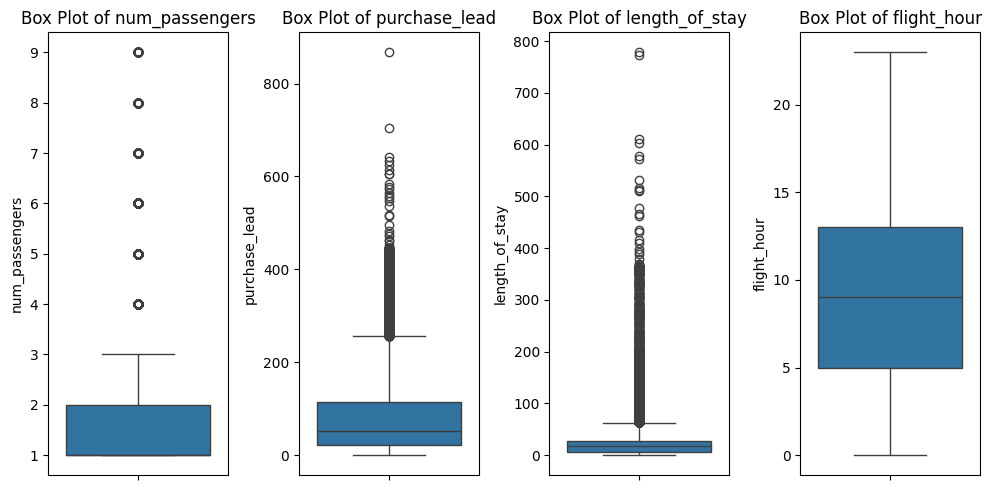

In [5]:
cols=['num_passengers','purchase_lead','length_of_stay','flight_hour']

fig, axes = plt.subplots(1, 4, figsize=(10, 5 ))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate through numerical columns and create box plots
for i, col in enumerate(cols):
    sns.boxplot(y=data[col], ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# Data Preprocessing

In [6]:
# Log transform 'purchase_lead' and 'length_of_stay' columns
for col in ['purchase_lead', 'length_of_stay']:
    # Add 1 to handle zero values before log transformation
    data[col] = np.log1p(data[col])


When log transformed the above columns, numerical columns seem to have less outliers and normalised.

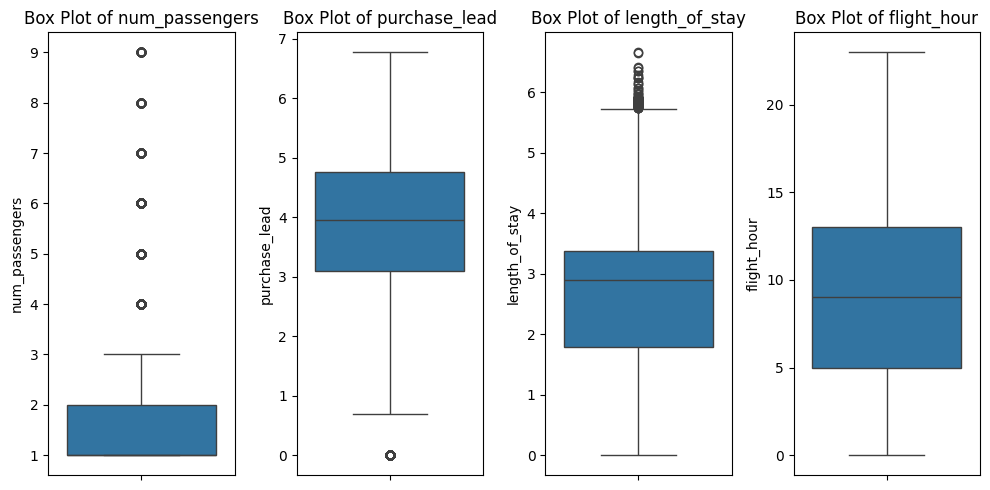

In [23]:
cols=['num_passengers','purchase_lead','length_of_stay','flight_hour']


fig, axes = plt.subplots(1, 4, figsize=(10, 5 ))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate through numerical columns and create box plots
for i, col in enumerate(cols):
    sns.boxplot(y=data[col], ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


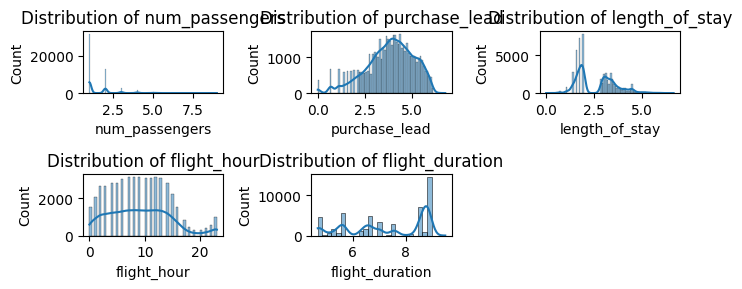

In [7]:
numerical_cols = ['num_passengers',  'purchase_lead',
       'length_of_stay', 'flight_hour',
        'flight_duration']

fig, axes = plt.subplots(2, 3, figsize=(7, 3 ))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate through numerical columns and create distribution plots
for i, col in enumerate(numerical_cols):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [8]:
# Create a mapping for flight days
flight_day_mapping = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}

# Apply label encoding to the 'flight_day' column
data['flight_day'] = data['flight_day'].map(flight_day_mapping)


In [9]:
# One-hot encode 'sales_channel'
sales_channel_encoded = pd.get_dummies(data['sales_channel'], prefix='sales_channel')
data = pd.concat([data, sales_channel_encoded], axis=1)
data = data.drop('sales_channel', axis=1)

# One-hot encode 'trip_type'
trip_type_encoded = pd.get_dummies(data['trip_type'], prefix='trip_type')
data = pd.concat([data, trip_type_encoded], axis=1)
data = data.drop('trip_type', axis=1)


In [ ]:
data['booking_origin'].unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

In [11]:
data['booking_origin'] =  data['booking_origin'].replace('Myanmar (Burma)', 'Myanmar')

In [12]:
def get_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except (KeyError, AttributeError):
        return "Unknown"  # Handle cases where country name is not found

data['continent'] = data['booking_origin'].apply(get_continent)
print(data[['booking_origin', 'continent']].head())


  booking_origin continent
0    New Zealand   Oceania
1    New Zealand   Oceania
2          India      Asia
3    New Zealand   Oceania
4          India      Asia


In [ ]:
data['continent'].unique()

array(['Oceania', 'Asia', 'Europe', 'Africa', 'Unknown', 'North America',
       'South America'], dtype=object)

In [13]:
continent_encoded = pd.get_dummies(data['continent'], prefix='continent')
data = pd.concat([data, continent_encoded], axis=1)
data = data.drop('continent', axis=1)

In [ ]:
data.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,continent_Unknown
0,2,5.572154,2.995732,7,6,1,0,0,5.52,0,...,False,False,True,False,False,False,False,True,False,False
1,1,4.727388,3.044522,3,6,0,0,0,5.52,0,...,False,False,True,False,False,False,False,True,False,False
2,2,5.497168,3.135494,17,3,1,1,0,5.52,0,...,False,False,True,False,True,False,False,False,False,False
3,1,4.574711,3.465736,4,6,0,0,1,5.52,0,...,False,False,True,False,False,False,False,True,False,False
4,2,4.234107,3.135494,15,3,1,0,1,5.52,0,...,False,False,True,False,True,False,False,False,False,False


In [15]:
data = data.drop('booking_origin', axis=1)

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'route' column
data['route'] = label_encoder.fit_transform(data['route'])

### Finding important features

In [19]:
X = data.drop('booking_complete', axis=1)
y = data['booking_complete']

fi_scores = mic(X, y)
fi_df = pd.DataFrame({"Columns": X.columns, "Feature_Importance_Score": fi_scores})
fi_df = fi_df.sort_values(by="Feature_Importance_Score", ascending=False)
fi_df


,Columns,Feature_Importance_Score
5,route,0.053658
19,continent_Oceania,0.030474
16,continent_Asia,0.029971
9,flight_duration,0.018004
14,trip_type_RoundTrip,0.012301
2,length_of_stay,0.010510
10,sales_channel_Internet,0.010236
6,wants_extra_baggage,0.008336
8,wants_in_flight_meals,0.007208
12,trip_type_CircleTrip,0.003163


<ipython-input-20-5bee30ed8269>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Feature_Importance_Score", y="Columns", data=fi_df, palette="crest")


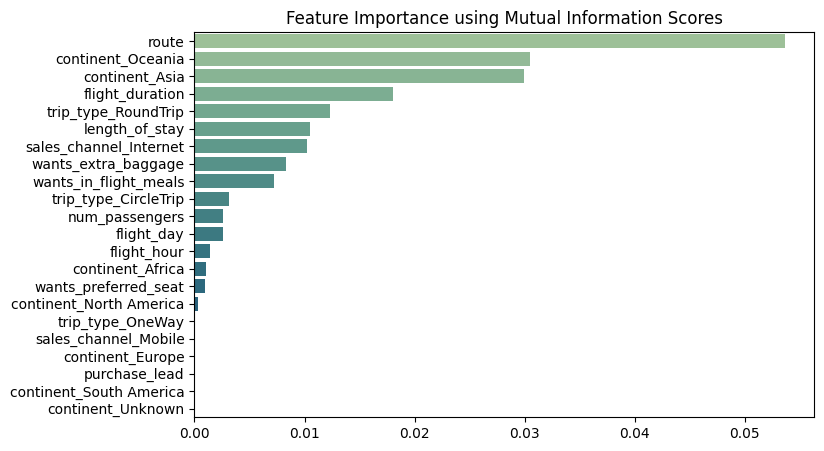

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Feature_Importance_Score", y="Columns", data=fi_df, palette="crest")
plt.title("Feature Importance using Mutual Information Scores")
plt.xlabel("")
plt.ylabel("")
plt.show()

### Dropping Route

Since Routes are not ordinal data, performing label encoding maynot be right. So besides performing one hot encoding and creating 800 additional columns let's put aside Route column for now and perform random forest on the rest of the columns.

In [25]:
data = data.drop('route', axis=1)

KeyError: "['route'] not found in axis"

In [27]:
X = data.drop('booking_complete', axis=1)
y = data['booking_complete']

### SMOTE for solving Class Imbalance

In [29]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Random Forest Model with Cross Validation

In [31]:
# Split the resampled data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled) # Stratified split!

# Initialize the Random Forest classifier (you can keep your hyperparameter values for now)
rf_classifier = RandomForestClassifier(n_estimators=150, max_depth=30,min_samples_leaf=2,min_samples_split=8, random_state=42)

# Cross-validation setup (using StratifiedKFold for classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X_train_full, y_train_full, cv=cv, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Standard deviation of cross-validation scores:", cv_scores.std())

# Now, train on the FULL training set after CV
rf_classifier.fit(X_train_full, y_train_full)

# Training accuracy (after CV and training on the full training set)
y_train_pred = rf_classifier.predict(X_train_full) # Use the full training data
training_accuracy = accuracy_score(y_train_full, y_train_pred)  # Use the full training labels
print(f"Training Accuracy (after CV): {training_accuracy}")

# Make predictions on the test set (ONLY AFTER CV AND TRAINING ON FULL TRAIN)
y_pred = rf_classifier.predict(X_test)

# Evaluate the model on the held-out test set (only once, at the very end)
print(classification_report(y_test, y_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Accuracy:", roc_auc_score(y_test, y_pred))

#--- Optional: More detailed cross-validation with cross_validate ---
from sklearn.model_selection import cross_validate

scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted',]  # Multiple metrics
cv_results = cross_validate(rf_classifier, X_train_full, y_train_full, cv=cv, scoring=scoring_metrics, return_train_score=True)

print("\nDetailed Cross-Validation Results:")
print(cv_results)

# Print mean scores for each metric
for metric in scoring_metrics:
    print(f"Mean {metric}: {cv_results['test_' + metric].mean()}")
    print(f"Mean Train {metric}: {cv_results['train_' + metric].mean()}")

Cross-validation scores: [0.85536856 0.86279121 0.86528992 0.86168884 0.86146836]
Mean cross-validation score: 0.8613213787021387
Standard deviation of cross-validation scores: 0.003271159908680268
Training Accuracy (after CV): 0.9503784816638495
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      8505
           1       0.88      0.85      0.86      8504

    accuracy                           0.87     17009
   macro avg       0.87      0.87      0.87     17009
weighted avg       0.87      0.87      0.87     17009

Testing Accuracy: 0.867129166911635
ROC AUC Accuracy: 0.8671281502276067

Detailed Cross-Validation Results:
{'fit_time': array([12.11834884, 11.95859647, 12.19466305, 12.85024071, 11.94008374]), 'score_time': array([0.49560213, 0.46979785, 0.50906491, 0.48851824, 0.50007558]), 'test_accuracy': array([0.85536856, 0.86279121, 0.86528992, 0.86168884, 0.86146836]), 'train_accuracy': array([0.94734328, 0.94839053, 0.94883148, 

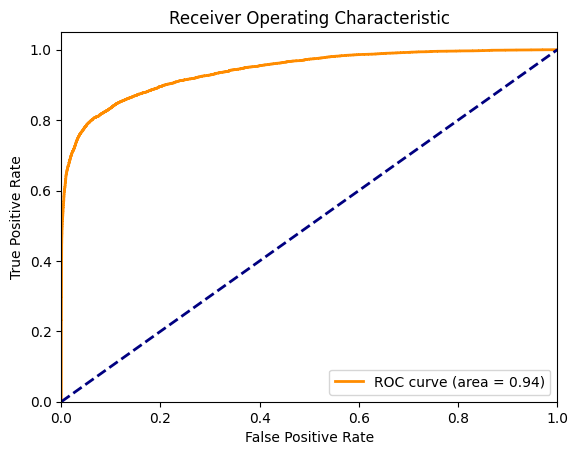

In [38]:
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]  # Probability of positive class


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

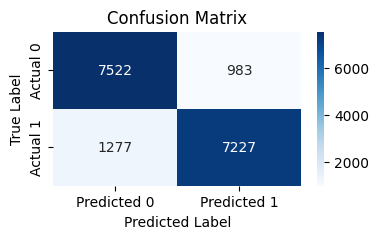

In [37]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Plotting important feautures

<ipython-input-36-dec32570956b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


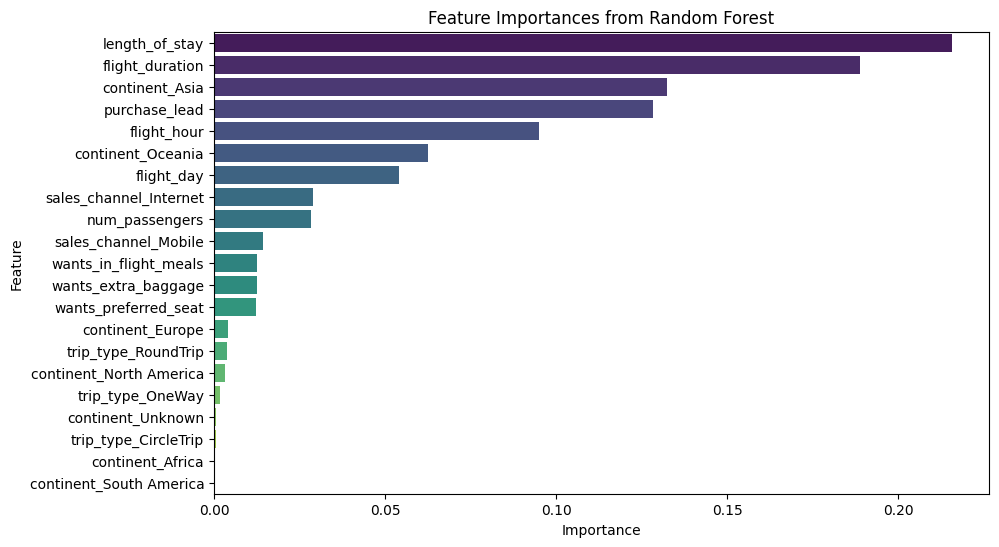

In [36]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()